In [5]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import find_peaks
from mpl_toolkits.basemap import Basemap

API_TIDE = "https://eco.odb.ntu.edu.tw/api/tide"

# Approximate Taiwan Strait domain (adjust to better match the paper's Figure 3)
LON0, LON1 = 117, 122
LAT0, LAT1 = 21.5, 25.5

# Map sampling stride. Larger value = coarser grid, faster response.
SAMPLE = 1

# Figure 3 timestamps (UTC / GMT) in original paper
# PHASES = [
#     ("A 09:30", "2013-06-27T09:30:00Z"),
#     ("B 11:00 (max flood)", "2013-06-27T11:00:00Z"),
#     ("C 15:30", "2013-06-27T15:30:00Z"),
#     ("D 17:00 (max ebb)", "2013-06-27T17:00:00Z"),
# ]

# Inset time series point (open water, adjustable)
INSET_LON, INSET_LAT = 119.645, 24.247
INSET_START = "2013-06-27T00:00:00Z"
INSET_END = "2013-06-28T23:59:00Z"

In [6]:
def fetch_map_sse(lon0: float, lon1: float, lat0: float, lat1: float, when: str, sample: int = 4):
    params = {
        "lon0": lon0,
        "lon1": lon1,
        "lat0": lat0,
        "lat1": lat1,
        "start": when,
        "append": "z",
        "sample": sample,
    }
    resp = requests.get(API_TIDE, params=params, timeout=60)
    if resp.status_code != 200:
        raise RuntimeError(f"API error: {resp.status_code} {resp.text[:200]}")
    data = resp.json()
    if not data:
        raise RuntimeError("Empty response from API.")
    return data


def fetch_inset_timeseries(lon: float, lat: float, start: str, end: str):
    params = {
        "lon0": lon,
        "lat0": lat,
        "start": start,
        "end": end,
        "append": "z",
        "sample": 1,
    }
    resp = requests.get(API_TIDE, params=params, timeout=60)
    if resp.status_code != 200:
        raise RuntimeError(f"API error: {resp.status_code} {resp.text[:200]}")
    data = resp.json()
    if not data:
        raise RuntimeError("Empty response from API.")
    return data


def map_to_grid(data: dict) -> pd.DataFrame:
    df = pd.DataFrame(
        {
            "lon": data["longitude"],
            "lat": data["latitude"],
            "z_cm": data["z"],
        }
    )
    # Convert cm -> m for plotting
    df["z_m"] = df["z_cm"] / 100.0
    grid = df.pivot_table(index="lat", columns="lon", values="z_m")
    # Remove fully empty rows/columns to avoid blank strips at domain edge.
    grid = grid.dropna(axis=0, how="all").dropna(axis=1, how="all")
    return grid


def choose_phase_times(inset_times: list[datetime], inset_z: np.ndarray) -> dict[str, datetime]:
    """
    Determine B=max flood and D=max ebb from the 2013-06-27~28 waveform,
    then generate A=B-1.5hr and C=D-1.5hr to match paper phase sequence.
    """
    t = np.array(inset_times)
    z = np.array(inset_z, dtype=float)

    pks, _ = find_peaks(z)
    trs, _ = find_peaks(-z)

    best_pair = None
    best_amp = -np.inf
    for i in pks:
        for j in trs:
            if j <= i:
                continue
            dt_h = (t[j] - t[i]).total_seconds() / 3600.0
            if dt_h < 3.0 or dt_h > 9.0:
                continue
            amp = z[i] - z[j]
            if amp > best_amp:
                best_amp = amp
                best_pair = (i, j)

    if best_pair is None:
        # Fallback: choose global maximum then nearest minimum after it.
        i = int(np.nanargmax(z))
        after = np.where(np.arange(len(z)) > i)[0]
        if len(after) == 0:
            raise RuntimeError("Cannot determine ebb phase after flood peak.")
        j = after[np.nanargmin(z[after])]
    else:
        i, j = best_pair

    b_time = t[i]
    d_time = t[j]
    a_time = b_time - timedelta(minutes=90)
    c_time = d_time - timedelta(minutes=90)
    return {"A": a_time, "B": b_time, "C": c_time, "D": d_time}


In [7]:
# Inset time series
inset = fetch_inset_timeseries(INSET_LON, INSET_LAT, INSET_START, INSET_END)
inset_times = [datetime.fromisoformat(t) for t in inset["time"]]
inset_z = np.array(inset["z"], dtype=float) / 100.0  # cm -> m

phase_times = choose_phase_times(inset_times, inset_z)
phases = [
    ("(A)", phase_times["A"], ""),
    ("(B)", phase_times["B"], "max flood elevation"),
    ("(C)", phase_times["C"], ""),
    ("(D)", phase_times["D"], "max ebb elevation"),
]
print("Selected UTC phase times from ODB waveform at (lat,lon)=24.247,119.645:")
for k, when, note in phases:
    txt = f"{k} {when.strftime('%Y-%m-%dT%H:%M:%S')}"
    if note:
        txt += f" [{note}]"
    print(txt)

Selected UTC phase times from ODB waveform at (lat,lon)=24.247,119.645:
(A) 2013-06-27T04:30:00
(B) 2013-06-27T06:00:00 [max flood elevation]
(C) 2013-06-27T10:30:00
(D) 2013-06-27T12:00:00 [max ebb elevation]


In [8]:
# Pre-fetch maps
# Pre-fetch maps at selected phase times
grids = []
for label, when, note in phases:
    data = fetch_map_sse(LON0, LON1, LAT0, LAT1, when.strftime("%Y-%m-%dT%H:%M:%S"), sample=SAMPLE)
    grid = map_to_grid(data)
    grids.append((label, when, note, grid))
print(grids)

[('(A)', datetime.datetime(2013, 6, 27, 4, 30, tzinfo=datetime.timezone.utc), '', lon        116.999999  117.033332  117.066665  117.099999  117.133332  \
lat                                                                     
21.500001    0.510653    0.507819    0.506112    0.503271    0.500274   
21.533334    0.511423    0.508234    0.505687    0.502301    0.501275   
21.566668    0.509412    0.507373    0.504070    0.502499    0.499658   
21.600001    0.508597    0.506946    0.503722    0.500590    0.498646   
21.633334    0.512026    0.507530    0.502630    0.500788    0.497599   
...               ...         ...         ...         ...         ...   
25.366668         NaN         NaN         NaN         NaN         NaN   
25.400001         NaN         NaN         NaN         NaN         NaN   
25.433334         NaN         NaN         NaN         NaN         NaN   
25.466668         NaN         NaN         NaN         NaN         NaN   
25.500001         NaN         NaN         

/tmp/ipykernel_2625215/2257360303.py:58: UserWarning: no explicit representation of timezones available for np.datetime64
  idx = int(np.argmin(np.abs(np.array(inset_times, dtype="datetime64[ns]") - np.datetime64(t0))))


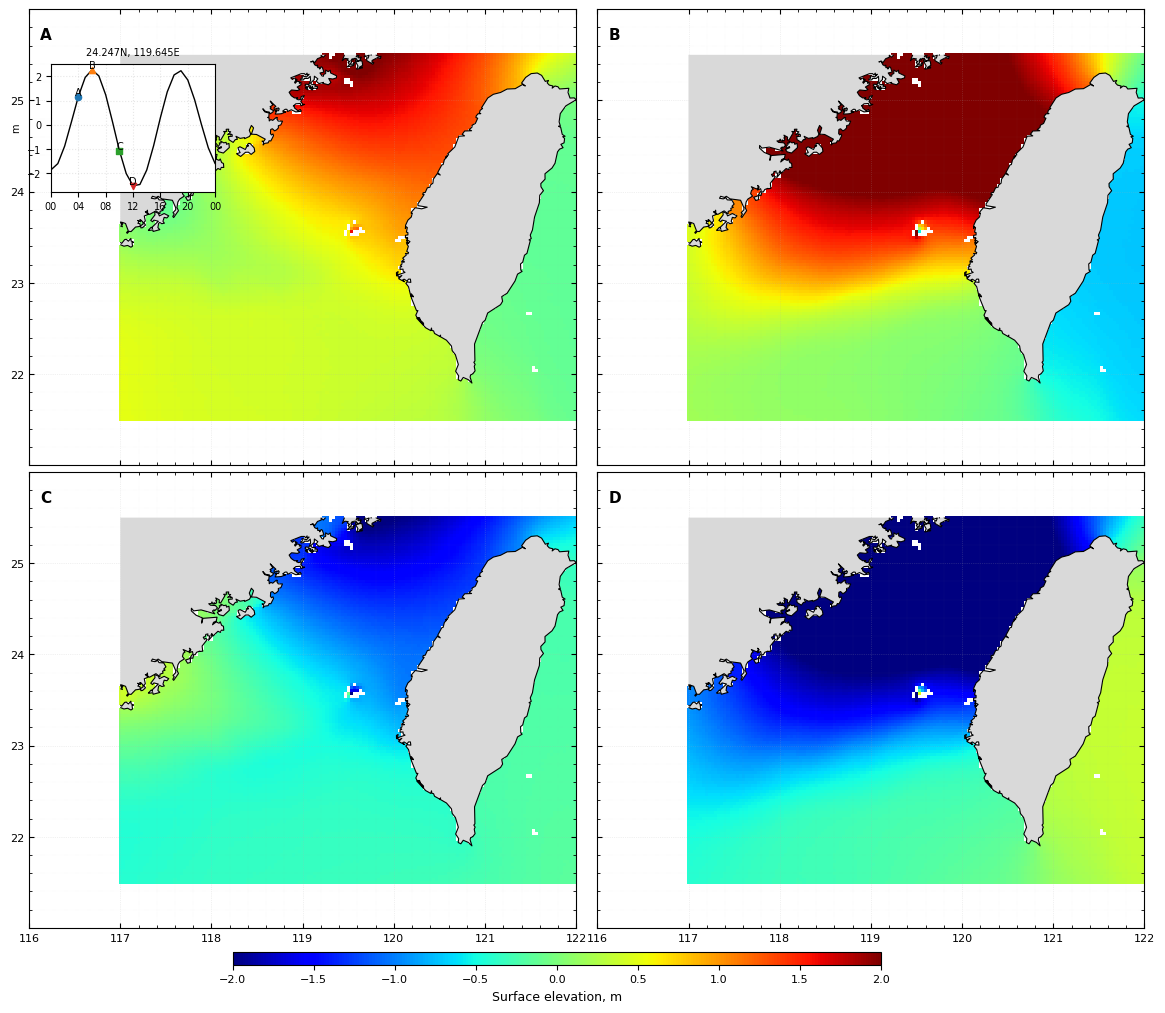

In [11]:
# Plot 2x2 panels
fig, axes = plt.subplots(2, 2, figsize=(12.0, 10.5), sharex=True, sharey=True)
axes = axes.ravel()

vmin, vmax = -2.0, 2.0
labels = ["A", "B", "C", "D"]

for ax, tag, (label, when, note, grid) in zip(axes, labels, grids):
    lon_grid, lat_grid = np.meshgrid(grid.columns.values, grid.index.values)
    bm = Basemap(
        projection="cyl",
        llcrnrlon=LON0,
        llcrnrlat=LAT0,
        urcrnrlon=LON1,
        urcrnrlat=LAT1,
        resolution="i",
        ax=ax,
    )
    # Use nearest-shaded pcolormesh for grid-like look
    m = bm.pcolormesh(
        lon_grid,
        lat_grid,
        grid.values,
        cmap="jet",
        vmin=vmin,
        vmax=vmax,
        shading="nearest",
        latlon=True,
    )
    bm.fillcontinents(color="#d9d9d9", lake_color="#d9d9d9", zorder=4)
    bm.drawcoastlines(linewidth=0.8, color="k", zorder=5)
    ax.text(0.02, 0.96, tag, transform=ax.transAxes, va="top", ha="left", fontsize=11, fontweight="bold")
    ax.set_xticks(np.arange(116, 122.1, 1.0))
    ax.set_yticks(np.arange(22, 25.6, 1.0))
    ax.set_xticks(np.arange(np.floor(LON0), np.ceil(LON1) + 0.001, 0.2), minor=True)
    ax.set_yticks(np.arange(np.floor(LAT0), np.ceil(LAT1) + 0.001, 0.2), minor=True)
    ax.tick_params(labelsize=8, direction="in", top=True, right=True)
    ax.tick_params(which="minor", length=2, direction="in", top=True, right=True)
    ax.grid(True, which="major", linestyle=":", linewidth=0.5, alpha=0.35)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.25, alpha=0.2)
    ax.set_xlabel("")
    ax.set_ylabel("")

# Shared colorbar: fixed at very bottom of full figure
cax = fig.add_axes([0.23, 0.085, 0.54, 0.012])
cbar = fig.colorbar(m, cax=cax, orientation="horizontal")
cbar.set_label("Surface elevation, m", fontsize=9)
cbar.set_ticks(np.arange(-2, 2.1, 0.5))
cbar.ax.tick_params(labelsize=8)

# Inset: place in panel A
ax0 = axes[0]
inset_ax = ax0.inset_axes([0.04, 0.60, 0.30, 0.28])
inset_ax.plot(inset_times, inset_z, color="k", linewidth=1.0, label="SSE")
marks = {"A": "o", "B": "^", "C": "s", "D": "v"}
for key, marker in marks.items():
    t0 = phase_times[key]
    idx = int(np.argmin(np.abs(np.array(inset_times, dtype="datetime64[ns]") - np.datetime64(t0))))
    inset_ax.scatter(inset_times[idx], inset_z[idx], s=20, marker=marker, label=key, zorder=3)
    inset_ax.text(inset_times[idx], inset_z[idx] + 0.05, key, fontsize=7, ha="center")
inset_ax.set_title("24.247N, 119.645E", fontsize=7)
# Show at least two full cycles
inset_start = datetime(2013, 6, 27, 0, 0, 0)
inset_end = datetime(2013, 6, 28, 0, 0, 0)
inset_ax.set_xlim(inset_start, inset_end)
inset_ticks = [datetime(2013, 6, 27, h, 0, 0) for h in [0, 4, 8, 12, 16, 20]] + [datetime(2013, 6, 28, 0, 0, 0)]
inset_ax.set_xticks(inset_ticks)
inset_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H"))
inset_ax.tick_params(axis="both", labelsize=7)
inset_ax.set_ylabel("m", fontsize=7)
inset_ax.grid(True, linestyle=":", alpha=0.3)
# Keep inset clean and similar to paper

fig.subplots_adjust(left=0.055, right=0.995, top=0.995, bottom=0.12, wspace=0.015, hspace=0.015)
plt.show()
